In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append('../../../do-mpc_fork/')
import do_mpc
import pandas as pd
import scipy.io as sio
import pathlib

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from nn_tools import NNPredictModel
from gp_tools import GPPredictModel

In [2]:
%matplotlib notebook

In [74]:
mpl.rcParams.update({
    'lines.linewidth':2,
    'font.size': 16,
    'figure.figsize': (9, 6),
    'axes.grid': False,
    'lines.markersize': 10,
    'text.usetex': True,
    'axes.unicode_minus': False,
    'ps.fonttype': 42,
    'pdf.fonttype': 42
})

In [4]:
plans = []

names = ['kite_sampling_01']

dh_list = []
res = []
for name in names:
    load_name = '../sampling/{name}/{name}_plan.pkl'.format(name=name)
    plan = do_mpc.tools.load_pickle(load_name)
    
    dh = do_mpc.sampling.DataHandler(plan)
    dh.set_param(data_dir = '../sampling/{}/sample_results/'.format(name))

    dh.set_post_processing('input', lambda data: data['_u'])
    dh.set_post_processing('states', lambda data: data['_x'])
    dh.set_post_processing('wind', lambda data: data['_p'])
    dh.set_post_processing('T_F', lambda data: data['_aux', 'T_F'])
    dh.set_post_processing('height', lambda data: data['_aux', 'height_kite'])
    dh.set_post_processing('traj_len', lambda data: data['_x'].shape[0])
    dh_list.extend(dh)
    res.extend(dh.filter(input_filter = lambda w_ref, E_0: np.abs(w_ref-10)<2 and np.abs(E_0-6)<2,
                        output_filter = lambda T_F: np.sum(T_F)/1e6>20))
    



---------------------------------------------------------------
Trying to access a non-existent element from the sampling plan.
---------------------------------------------------------------


Choose the last trajectories as test cases (identical for GP and NN training):

In [5]:
n_test = 20

test_res = res[-n_test:]

# Neural Network

In [6]:
export_name = 'S01_NN_M01'
export_path = './nn_models/{}/'

nn_model_aux = do_mpc.tools.load_pickle(export_path.format(export_name) + export_name + '_aux.pkl')
nn_model = keras.models.load_model(export_path.format(export_name))

2021-11-19 17:03:12.584977: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-19 17:03:12.585148: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
nn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 20)                140       
_________________________________________________________________
hidden_2 (Dense)             (None, 20)                420       
_________________________________________________________________
output (Dense)               (None, 5)                 105       
Total params: 665
Trainable params: 665
Non-trainable params: 0
_________________________________________________________________


In [8]:
nn_in = nn_model.get_layer('input')
nn_ll = nn_model.get_layer('hidden_2')

activation_model = keras.backend.function(nn_in.input, nn_ll.output)

In [9]:
case = 0
x0 = (test_res[case]['states'][0]).reshape(-1,1)

pm = NNPredictModel(nn_model, activation_model, nn_model_aux['a_train'], 
                    nn_model_aux['in_scaler'], nn_model_aux['out_scaler'], x0)

for k in range(test_res[case]['states'].shape[0]):
    u0 = test_res[case]['input'][k]
    p = test_res[case]['wind'][k]
    pm.make_step(u0,p)

<IPython.core.display.Javascript object>


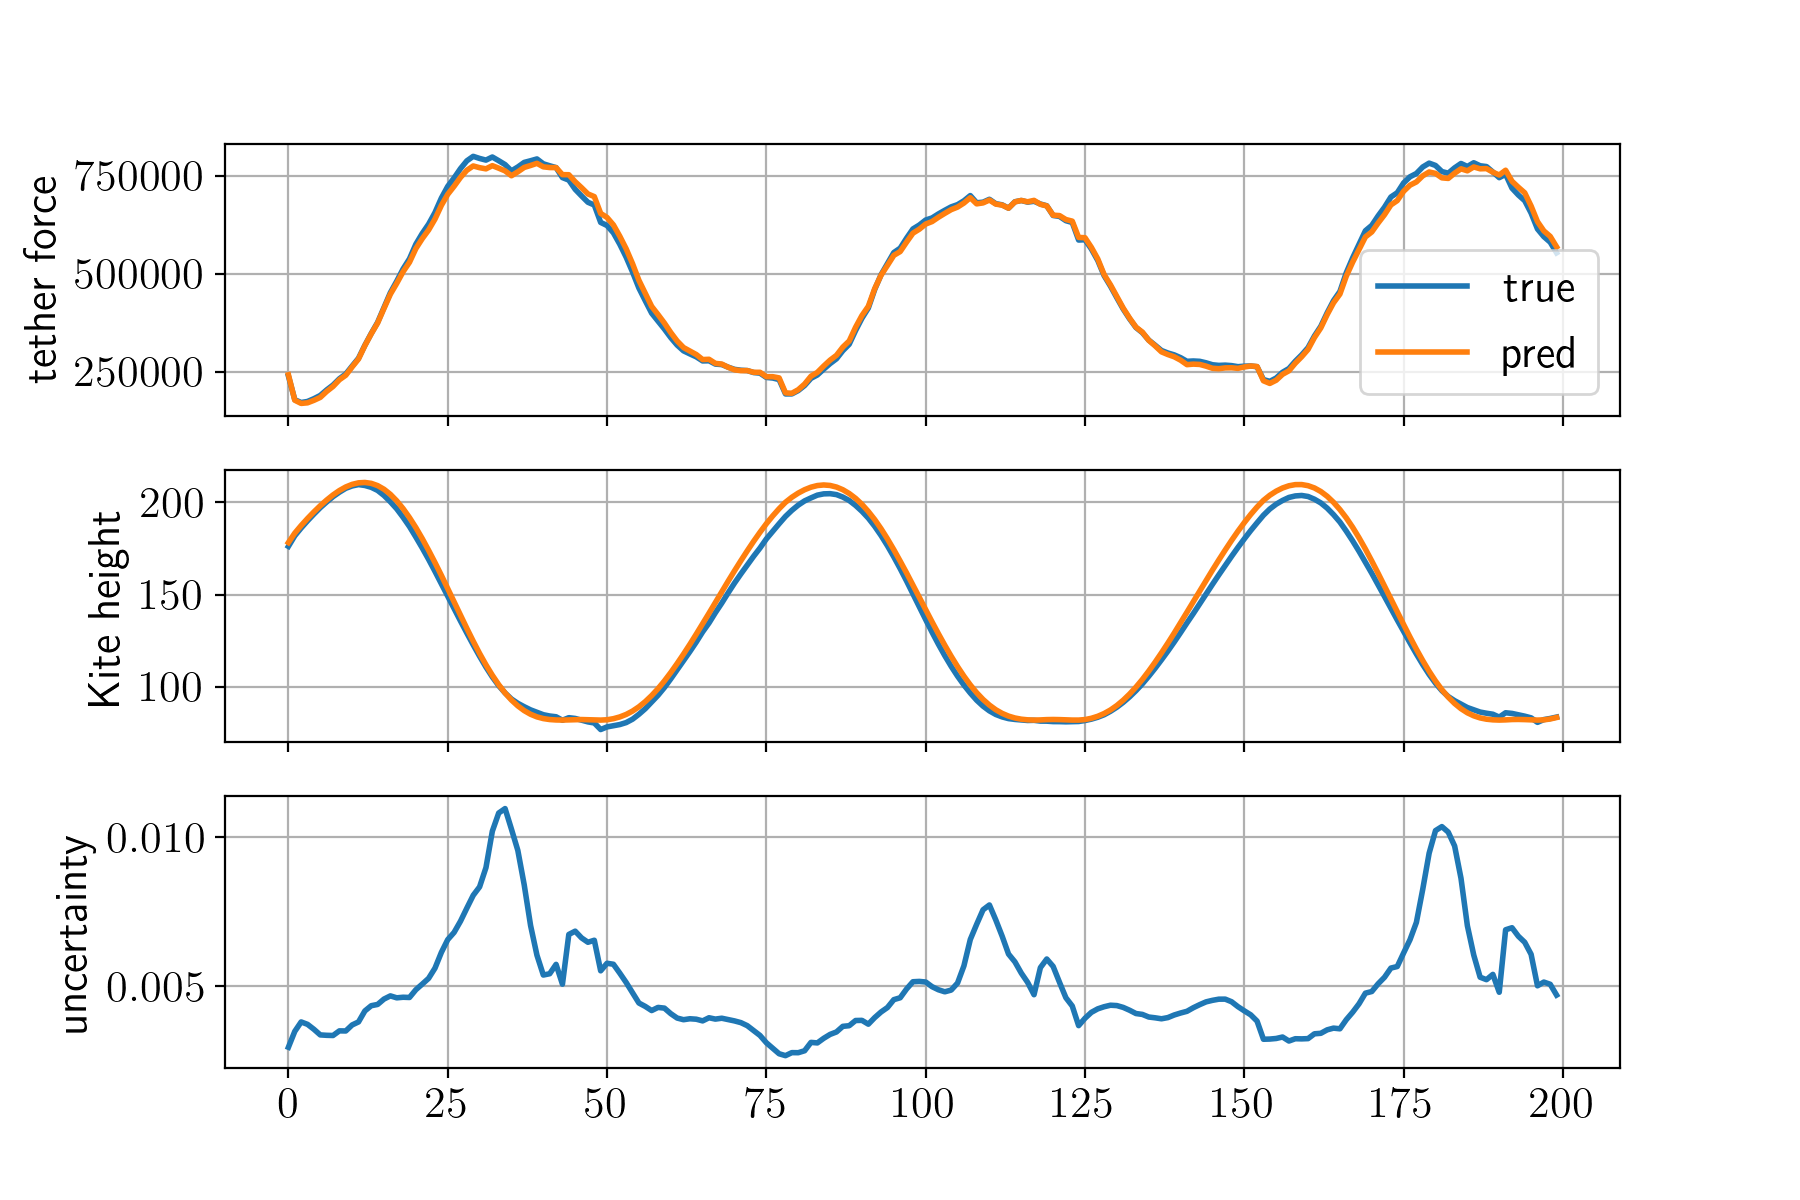

Text(0, 0.5, 'uncertainty')

In [10]:
fig, ax = plt.subplots(3,1, sharex=True)

ax[0].plot(pm.aux[:,0],label='true')
ax[0].plot(test_res[case]['T_F'], label='pred')
ax[0].set_ylabel('tether force')
ax[0].legend()

ax[1].plot(pm.aux[:,1])
ax[1].plot(test_res[case]['height'])
ax[1].set_ylabel('Kite height')

ax[2].plot(pm.v)
ax[2].set_ylabel('uncertainty')



# Gaussian Process

In [11]:
export_name = 'S01_GP_M01_200'
export_path = './gp_models/{}/'

gp_model = do_mpc.tools.load_pickle(export_path.format(export_name) + export_name + '_gp.pkl')

gpr = GaussianProcessRegressor(kernel=RBF(length_scale=gp_model['l']),alpha=gp_model['alpha'], optimizer=None).fit(
    gp_model['X_train'], gp_model['Y_train'])

In [12]:
case = 0

x0 = (test_res[case]['states'][0]).reshape(-1,1)

pm_gp = GPPredictModel(gpr, gp_model['in_scaler'], gp_model['out_scaler'], x0)


for k in range(test_res[case]['states'].shape[0]):
    u0 = test_res[case]['input'][k]
    p = test_res[case]['wind'][k]
    pm_gp.make_step(u0,p)

<IPython.core.display.Javascript object>


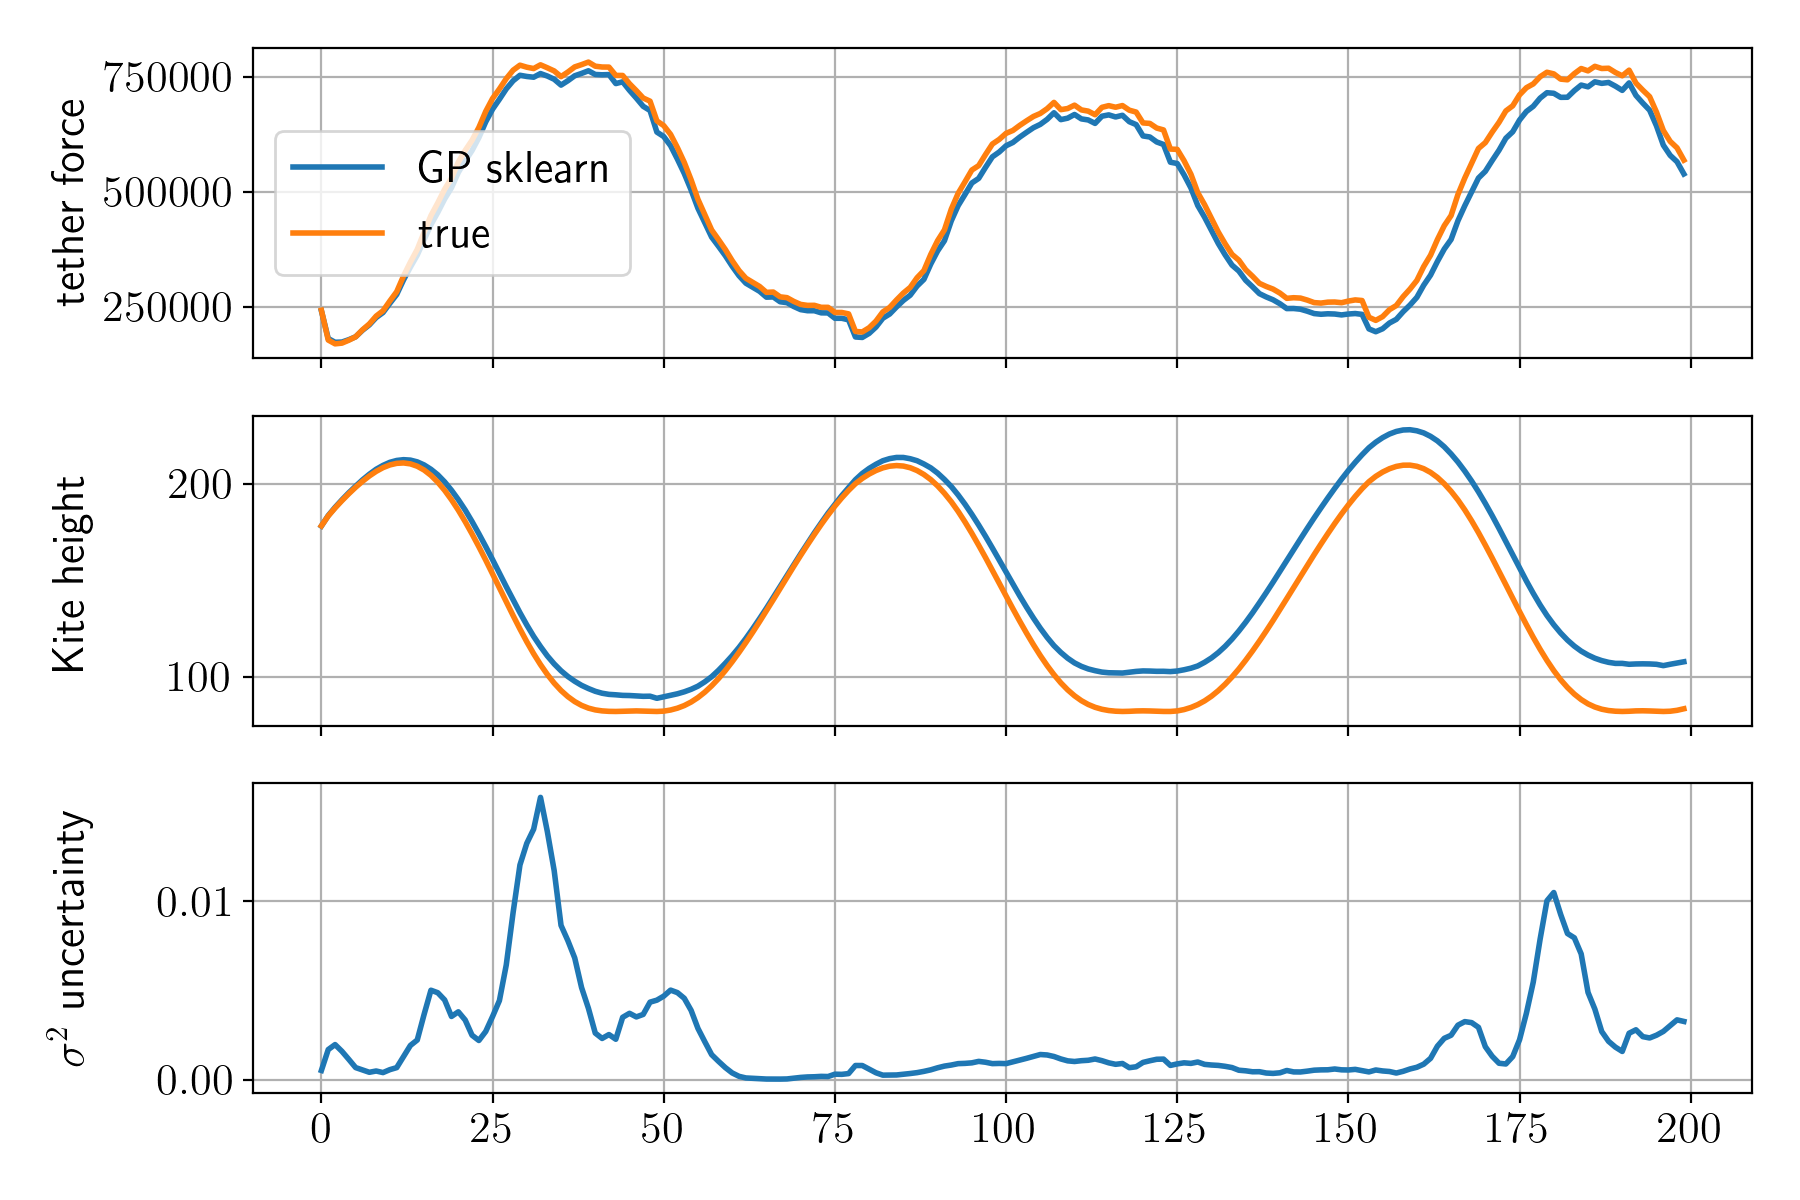

In [13]:
fig, ax = plt.subplots(3,1, sharex=True)

ax[0].plot(pm_gp.aux[:,0],'-',label='GP sklearn')
ax[0].plot(test_res[case]['T_F'], label='true')
ax[0].set_ylabel('tether force')
ax[0].legend()

ax[1].plot(pm_gp.aux[:,1],'-')
ax[1].plot(test_res[case]['height'])
ax[1].set_ylabel('Kite height')

ax[2].plot(pm_gp.v**2,'-')
ax[2].set_ylabel('$\sigma^2$ uncertainty')

fig.align_ylabels()
fig.tight_layout()

# Comparison

In [14]:
nn_traj = {'x': [], 'v': [], 'aux':[]}
gp_traj = {'x': [], 'v': [], 'aux':[]}

for i, res_i in enumerate(test_res):
    x0 = (res_i['states'][0]).reshape(-1,1)
    pm_nn = NNPredictModel(nn_model, activation_model, nn_model_aux['a_train'], 
                    nn_model_aux['in_scaler'], nn_model_aux['out_scaler'], x0)
    pm_gp = GPPredictModel(gpr, gp_model['in_scaler'], gp_model['out_scaler'], x0)

    for k in range(res_i['states'].shape[0]):
        u0 = res_i['input'][k]
        p = res_i['wind'][k]
        pm_nn.make_step(u0,p)
        pm_gp.make_step(u0,p)
        
    nn_traj['v'].append(pm_nn.v)
    gp_traj['v'].append(pm_gp.v)
    
    nn_traj['x'].append(pm_nn.x)
    gp_traj['x'].append(pm_gp.x)
    
    nn_traj['aux'].append(pm_nn.aux)
    gp_traj['aux'].append(pm_gp.aux)

In [15]:
nn_err = {'x': [], 'aux':[]}
gp_err = {'x': [], 'aux':[]}

for i, res_i in enumerate(test_res):
    res_i_aux = np.concatenate((res_i['T_F'], res_i['height']),axis=1)
    
    nn_x_err_i = np.sum(np.abs(res_i['states']-nn_traj['x'][i][:-1,:]),axis=0)
    nn_aux_err_i = np.sum(np.abs(res_i_aux-nn_traj['aux'][i]),axis=0)
    
    gp_x_err_i = np.sum(np.abs(res_i['states']-gp_traj['x'][i][:-1,:]),axis=0)
    gp_aux_err_i = np.sum(np.abs(res_i_aux-gp_traj['aux'][i]),axis=0)
    
    nn_err['x'].append(nn_x_err_i)
    nn_err['aux'].append(nn_aux_err_i)
    
    gp_err['x'].append(gp_x_err_i)
    gp_err['aux'].append(gp_aux_err_i)

In [92]:
mean_sum_err_nn = np.mean(nn_err['aux'],axis=0)

In [93]:
mean_sum_err_gp = np.mean(gp_err['aux'],axis=0)

In [100]:
improvement_nn_vs_gp = (mean_sum_err_nn-mean_sum_err_gp)/mean_sum_err_gp*100

print(f'NN reduced error for T_f by {improvement_nn_vs_gp[0]:.2f}% and h by {improvement_nn_vs_gp[1]:.2f}%.')

NN reduced error for T_f by -2.35% and h by -20.83%.


<IPython.core.display.Javascript object>


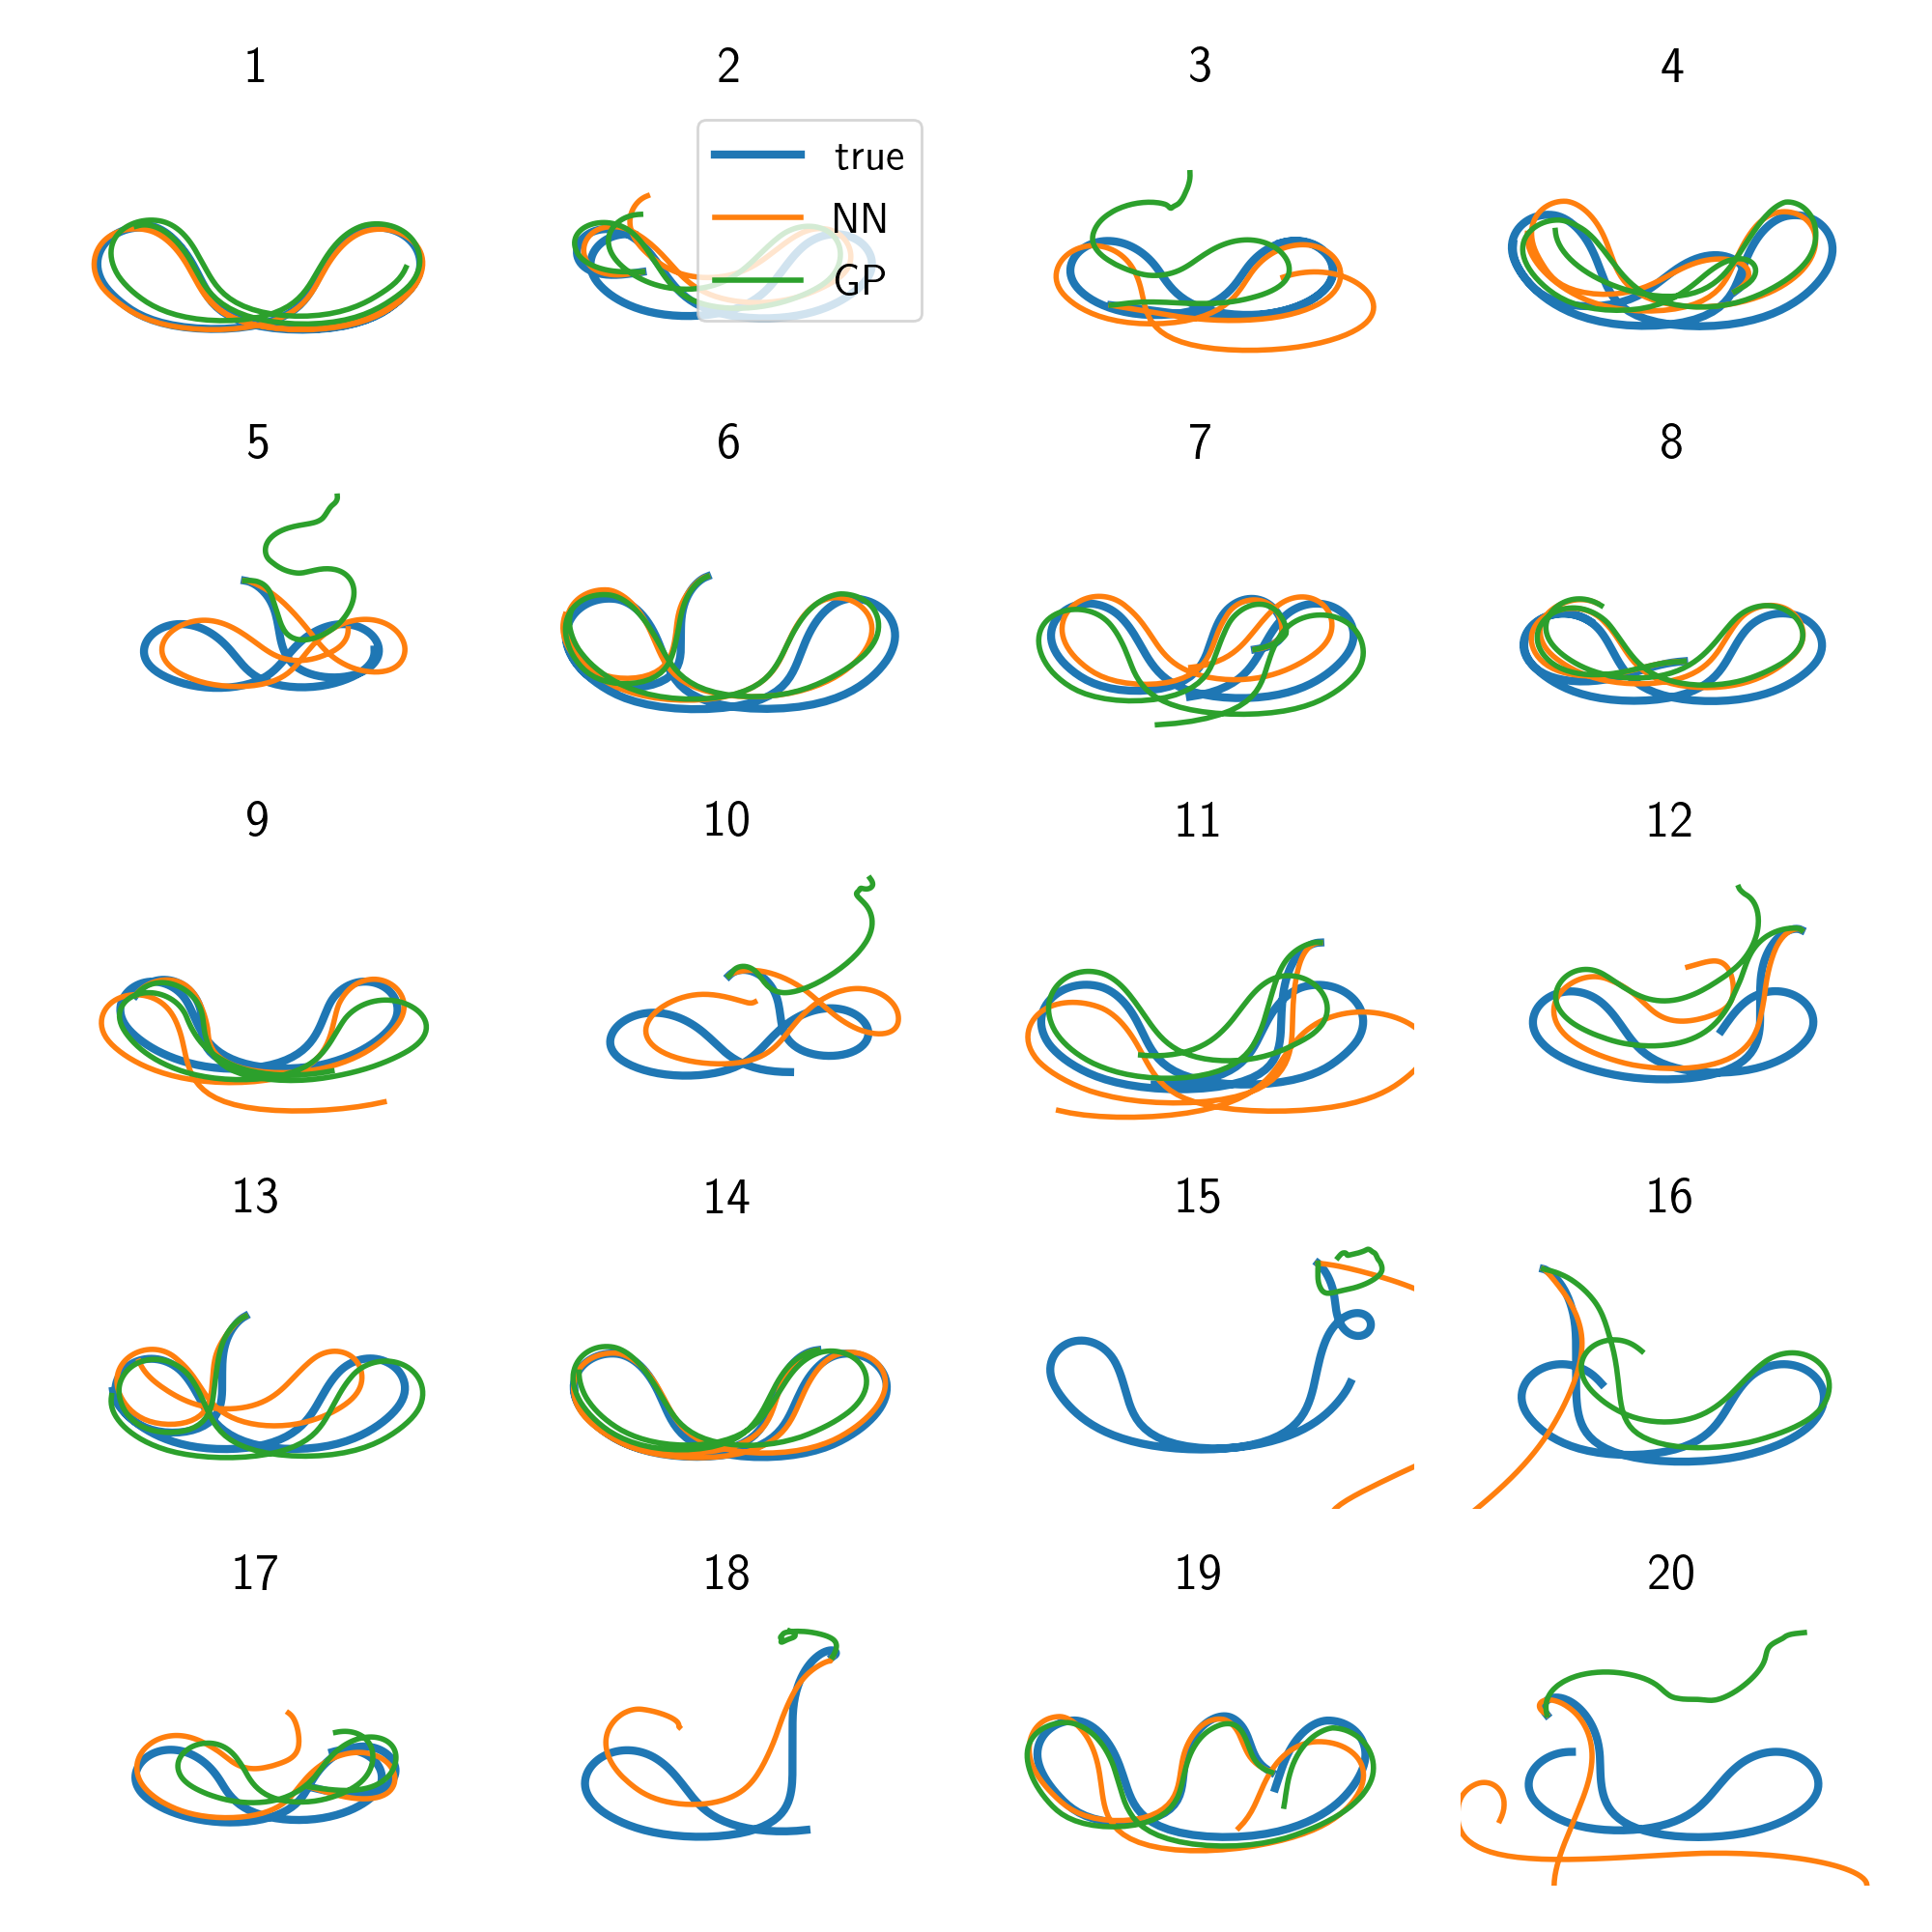

(0.0, 1.4)

In [102]:
n_eval = 20

n_row = int(np.ceil(np.sqrt(n_eval)))
n_col = int(np.ceil(n_eval/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(10,10))
for i, res_i in enumerate(test_res[:n_eval]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0],linewidth=3, label='true')
    ax[i//n_col, np.mod(i,n_col)].plot(nn_traj['x'][i][:,1], nn_traj['x'][i][:,0], label='NN')
    ax[i//n_col, np.mod(i,n_col)].plot(gp_traj['x'][i][:,1], gp_traj['x'][i][:,0], label='GP')
    ax[i//n_col, np.mod(i,n_col)].set_title(i+1)
    
for i in range(ax.size):
    ax[i//n_col, np.mod(i,n_col)].axis('off')

fig.tight_layout()

ax[0,1].legend()

ax[0,0].set_xlim(-1.5,1.5)
ax[0,0].set_ylim(0,1.4)

#fig.savefig('Kite_GP_NN_open_loop_prediction.pdf',format='pdf',pad_inches=0)

<IPython.core.display.Javascript object>


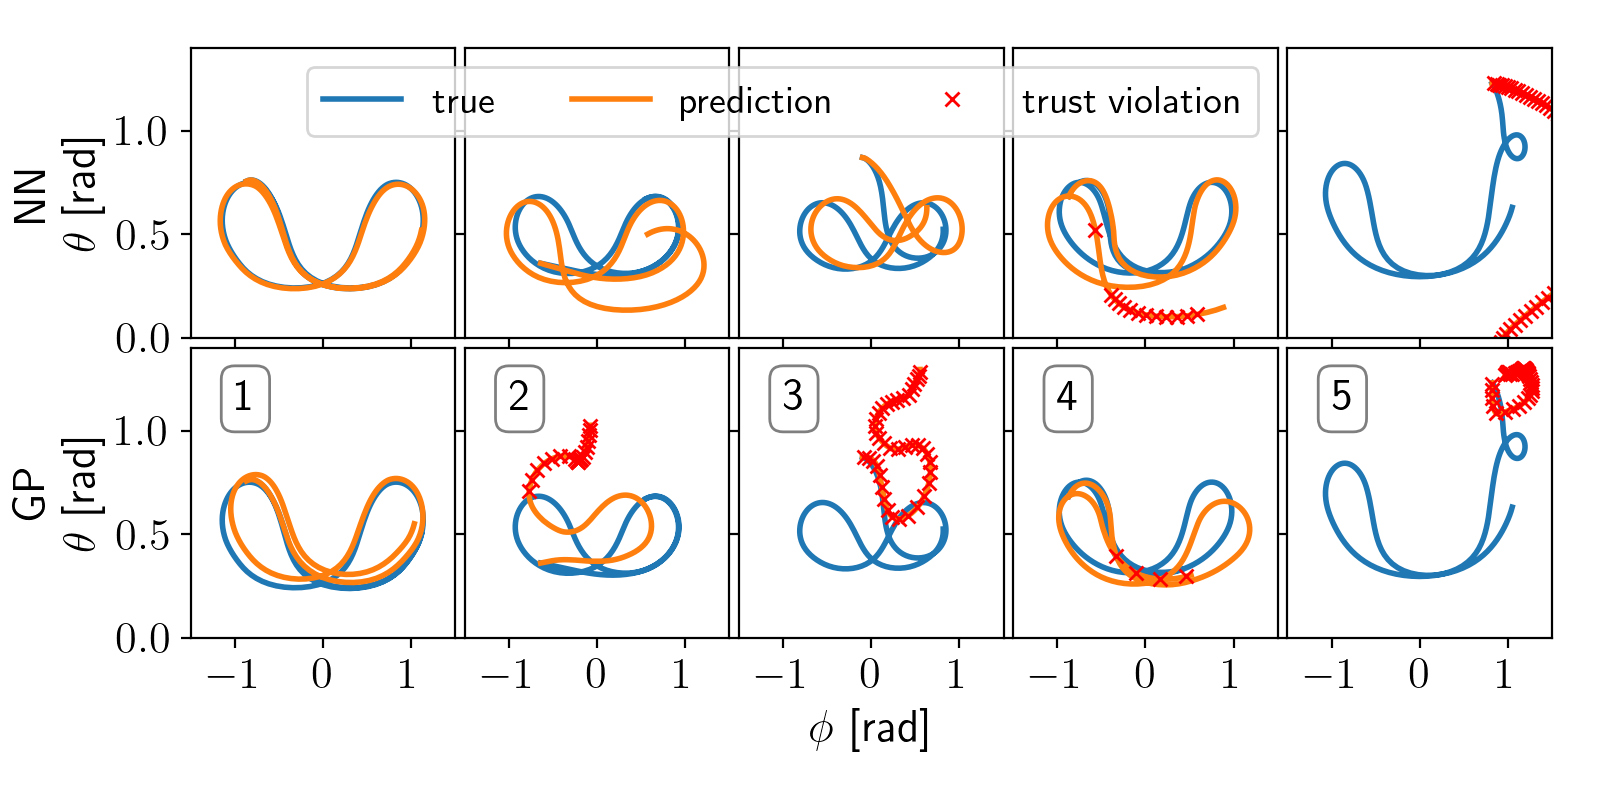

In [91]:
n_eval = 6

cases = [0,2,4,8,14]
n_eval = len(cases)

fig, ax = plt.subplots(2,n_eval,sharex=True,sharey=True, figsize=(8,4))

trust_threshold_nn = 0.02
trust_threshold_gp = 0.2

box_props = dict(boxstyle='round', edgecolor='black', facecolor='white', alpha=0.5)

for k,i in enumerate(cases):
    ax[0,k].plot(test_res[i]['states'][:,1],test_res[i]['states'][:,0], label='true')
    ax[0,k].plot(nn_traj['x'][i][:,1], nn_traj['x'][i][:,0], label='prediction')
    
    viol_ind = (nn_traj['v'][i]>= trust_threshold_nn).flatten()
    ax[0,k].plot(nn_traj['x'][i][1:,:][viol_ind,1], nn_traj['x'][i][1:,:][viol_ind,0],
                                      'x', color='red', markersize=5, label='trust violation')
    
    
for k,i in enumerate(cases):
    ax[1,k].text(-1,1.1,k+1, bbox=box_props)
    
    ax[1,k].plot(test_res[i]['states'][:,1],test_res[i]['states'][:,0], label='true')
    ax[1,k].plot(gp_traj['x'][i][:,1], gp_traj['x'][i][:,0], label='prediction')
    
    viol_ind = (gp_traj['v'][i]>= trust_threshold_gp).flatten()
    ax[1,k].plot(gp_traj['x'][i][1:,:][viol_ind,1], gp_traj['x'][i][1:,:][viol_ind,0],
                                      'x', color='red',markersize=5,markevery=5, label='trust violation')

ax[0,0].set_ylabel('NN\n' + r'$\theta$ [rad]') 
ax[1,0].set_ylabel('GP\n' + r'$\theta$ [rad]')
ax[1,n_eval//2].set_xlabel(r'$\phi$ [rad]')

fig.tight_layout(h_pad=0, w_pad=0)
ax[0,3].legend(ncol=3,loc=1, fontsize=14)

ax[0,0].set_xlim(-1.5,1.5)
ax[0,0].set_ylim(0,1.4)

fig.savefig('./figures/Kite_GP_NN_open_loop_prediction.pdf',format='pdf', pad_inches=0)